## M5 Forecast Competition - Accuracy

This notebook is a product for submission into the [M5 Forecast Competition](https://www.kaggle.com/c/m5-forecasting-accuracy) with more information from the organizer, [MOFC](https://mofc.unic.ac.cy/m5-competition/). The ultimate goal of the competition is "... to advance the theory of forecasting and improve its utilization by business and non-profit organizations".

### Credits

This first section of this notebook creating a cleaned dataframe is based off [M5 under-0.50 optimized](https://www.kaggle.com/poedator/m5-under-0-50-optimized) by [@poedator](https://www.kaggle.com/poedator) on Kaggle.

In [0]:
%tensorflow_version 2.x

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from  datetime import datetime, timedelta
import gc
import lightgbm as lgb
import seaborn as sns
sns.set(style="whitegrid")
plt.figure(figsize=[16,12])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<Figure size 1152x864 with 0 Axes>

<Figure size 1152x864 with 0 Axes>

# Section 1: Load Data and Benchmark

### 1A: Load data and set data types

In [0]:
CAL_DTYPES = {"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [4]:
h = 28 
max_lags = 57
tr_last = 1913
fday = datetime(2016,4, 25) 
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [0]:
def create_dt(is_train = True, nrows = None, first_day = 1200):
    prices = pd.read_csv('drive/My Drive/m5_forecast_accuracy/sell_prices.csv', dtype = PRICE_DTYPES)
    prices = reduce_mem_usage(prices)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv("drive/My Drive/m5_forecast_accuracy/calendar.csv", dtype = CAL_DTYPES)
    cal = reduce_mem_usage(cal)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv("drive/My Drive/m5_forecast_accuracy/sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

Memory reduction function based on min and max of series credit to @hiroyuki_kageyama on Qiita:  [https://qiita.com/hiroyuki_kageyama/items/02865616811022f79754](https://qiita.com/hiroyuki_kageyama/items/02865616811022f79754)

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns毎に処理
        col_type = df[col].dtypes
        if col_type in numerics: #numericsのデータ型の範囲内のときに処理を実行. データの最大最小値を元にデータ型を効率的なものに変更
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
def create_fea(dt):
    lags = [1, 7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [1, 7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    
    
    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
    
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [0]:
FIRST_DAY = 1 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !

In [9]:
%%time
df = create_dt(is_train=True, first_day= FIRST_DAY)
df.shape

Mem. usage decreased to 45.77 Mb (22.2% reduction)
Mem. usage decreased to  0.06 Mb (18.9% reduction)
CPU times: user 33.6 s, sys: 4.91 s, total: 38.5 s
Wall time: 41.4 s


In [10]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.459961
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.459961


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int8          
 12  month         int8          
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float16       
 19  snap_TX       float16       
 20  snap_WI       float16       
 21  sell_price    float16       
dtypes: datetime64[ns](1), float16(4), float32(1), int16(12), int8(2)

In [10]:
%%time

create_fea(df)
df.shape

CPU times: user 6min 16s, sys: 3.44 s, total: 6min 19s
Wall time: 6min 19s


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 37 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   store_id      int16         
 4   cat_id        int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float16       
 19  snap_TX       float16       
 20  snap_WI       float16       
 21  sell_price    float16       
 22  lag_1         float32       
 23  lag_7         float32       
 

In [14]:
df.head()

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_7,lag_28,rmean_1_1,rmean_7_1,rmean_28_1,rmean_1_7,rmean_7_7,rmean_28_7,rmean_1_28,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,29
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961,12.0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,30
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961,15.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,31
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.459961,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.459961,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2


In [11]:
tsdf = df.loc[df.id == df.id[0]]
ts = tsdf.sales
tsdf

,id,item_id,dept_id,store_id,cat_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,lag_1,lag_7,lag_28,rmean_1_1,rmean_7_1,rmean_28_1,rmean_1_7,rmean_7_7,rmean_28_7,rmean_1_28,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,2,1,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,29
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,3,2,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961,12.0,NaN,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1,30
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,1,3,1,2011,0,0,0,0,0.0,0.0,0.0,0.459961,15.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,31
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,5,4,2,2011,0,0,0,0,1.0,1.0,0.0,0.459961,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,6,5,2,2011,0,0,0,0,1.0,0.0,1.0,0.459961,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45753600,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1909,4.0,2016-04-20,11612,6,5,4,2016,0,0,0,0,0.0,0.0,0.0,0.479980,3.0,8.0,10.0,3.0,8.0,10.0,7.571429,9.285714,7.571429,8.000000,7.928571,6.178571,16,2,20
45753601,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1910,6.0,2016-04-21,11612,4,6,4,2016,0,0,0,0,0.0,0.0,0.0,0.479980,4.0,4.0,2.0,4.0,4.0,2.0,7.000000,6.142857,7.857143,7.785714,8.071428,6.107143,16,2,21
45753602,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1911,3.0,2016-04-22,11612,0,7,4,2016,0,0,0,0,0.0,0.0,0.0,0.479980,6.0,0.0,0.0,6.0,0.0,0.0,7.285714,5.000000,5.428571,7.928571,7.464286,5.678571,16,2,22
45966991,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1912,2.0,2016-04-23,11613,2,1,4,2016,0,0,0,0,0.0,0.0,0.0,0.479980,3.0,0.0,0.0,3.0,0.0,0.0,7.714286,3.285714,3.857143,8.035714,7.071429,5.071429,16,2,23


In [16]:
ts.index

Int64Index([       0,        1,        2,        3,        4,        5,
                   6,    76524,    76525,    76526,
            ...
            45540172, 45753596, 45753597, 45753598, 45753599, 45753600,
            45753601, 45753602, 45966991, 45966992],
           dtype='int64', length=1913)

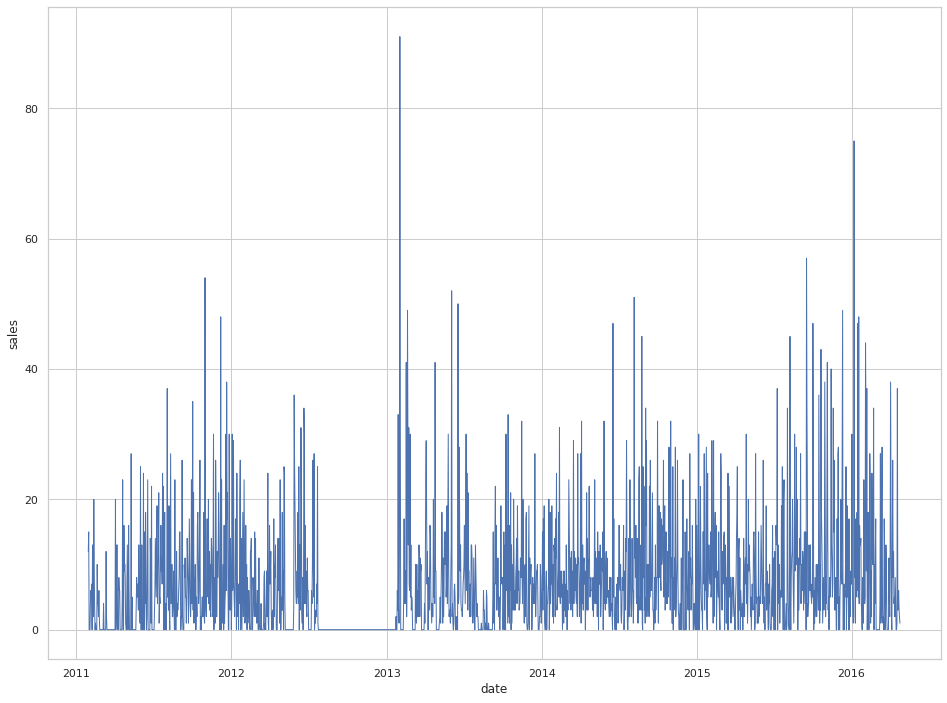

In [17]:
plt.figure(figsize=[16,12])
sns.lineplot(data=tsdf, x='date', y='sales', palette="tab10", linewidth=1)

## 1B: Create Benchmarks

### Moving Average

In [0]:
# Utility Error
class ParameterError(Exception):
  pass

In [0]:
# Calculate root mean squared scaled error
def rmsse(orig_series, pred_series, h=1, intermittent = True):
  '''
  Calculates Root Mean Scaled Squared Error as defined in competitor's guide.

  Parameters
  ----------
  orig_series: A numpy compatible object of the original series.

  pred_series: A numpy compatible object of a model fit.

  h: The forecast horizon assumed to be appended on the tail of orig_series and
  pred_series. A value of 1 assumes no forecast and no averaging occurs.

  intermittent: If the RMSSE should be calculated for areas of series' value 
  below 0.

  Returns
  -------
  The RMSSE
  '''

  s1 = np.array(orig_series)
  s2 = np.array(pred_series)

  if intermittent:
    nz_idx = s1 > 0
    s1 = s1[nz_idx]
    s2 = s2[nz_idx]

  # Squared error
  se = np.sum(np.square(s1 - s2))
  # Scaled diff
  sdiff = ( 1 / (len(s1) - 1) ) * np.sum(np.square(s1[1:] - np.diff(s1))) + 1e-7

  rmsse = np.sqrt( 1/h * (se / sdiff) )

  return rmsse

In [0]:
def moving_average(series, windows, h=0):
  '''
  Calculates rolling mean using provided time windows. If multiple windows are
  given, outputs a list of MA series with their respective window.

  Parameters
  ----------
  series: A Pandas Series object to calculate the MA on.

  windows: An iterable object which lists the number of previous levels to be 
  considered.

  h: A forecast horizon for prediction. h = 0 means no prediction.


  Returns
  -------
  A dictionary with the following items:
    'series': The original series modeled.
    'in_sample_fit': A pandas DataFrame of requested moving averages.
    'forecast': A pandas DataFrame with predictions up to h.
  '''

  rolling_means = []
  preds_list = []

  for w in windows:
    rolling_mean = series.rolling(window=w).mean()
    rolling_mean[:w-1] = series[:w-1]
    rolling_mean.name = f'MA{w}'
    rolling_means.append(rolling_mean)

    if h > 0:
      preds = rolling_mean[-w:]

      for i in range(h):
        # Do not need to calculate rolling mean again for full series, only last
        pred = preds[-w:].rolling(window=w).mean()[-1:]
        preds = preds.append(pred, ignore_index = True)

      # Only keep the predicted entries
      preds = preds.iloc[w:]
      preds = preds.reset_index(drop=True)
      preds = preds.rename(f'hMA{w}')

    preds_list.append(preds)

  preds_df = pd.DataFrame(preds_list).T
  rolling_means = pd.DataFrame(rolling_means).T
  
  return_dict = {
      'series': series,
      'in_sample_fit': rolling_means,
      'forecast': preds_df,
  }

  return return_dict

In [21]:
# Test MA
mas = moving_average(ts, [4,3,2], h=20)
mas

{'forecast':         hMA4      hMA3      hMA2
 0   5.812500  3.333333  2.000000
 1   4.140625  3.000000  1.750000
 2   4.175781  2.777778  1.875000
 3   4.282227  3.037037  1.812500
 4   4.602783  2.938272  1.843750
 5   4.300354  2.917695  1.828125
 6   4.340286  2.964335  1.835938
 7   4.381413  2.940101  1.832031
 8   4.406209  2.940710  1.833984
 9   4.357065  2.948382  1.833008
 10  4.371243  2.943064  1.833496
 11  4.378983  2.944052  1.833252
 12  4.378375  2.945166  1.833374
 13  4.371417  2.944094  1.833313
 14  4.375004  2.944437  1.833344
 15  4.375945  2.944566  1.833328
 16  4.375185  2.944366  1.833336
 17  4.374388  2.944456  1.833332
 18  4.375130  2.944463  1.833334
 19  4.375162  2.944428  1.833333,
 'in_sample_fit':             MA4        MA3   MA2
 0         12.00  12.000000  12.0
 1         15.00  15.000000  13.5
 2          0.00   9.000000   7.5
 3          6.75   5.000000   0.0
 4          3.75   0.000000   0.0
 ...         ...        ...   ...
 45753600  11.25  

### Exponential Smoothing

In [0]:
# Utility functions for smoothing params
def check_smoothing_params(params):
  for p in params:
      if (p * 100) - int(p * 100) > 1e-3:
        raise ParameterError("Only 2 significant digits for smoothing parameters are accepted. Received {}".format(p))
      if (p > 0.99) or (p < 1e-3):
        raise ParameterError("Smoothing parameters must be between 0 and 1 and greater than 0.001. Received {}".format(p))


In [0]:
def exponential_smoothing(series, alphas, h = 0):
  '''
  Calculates exponential smoothing model on given series and smoothing params.

  Parameters
  ----------
  series: A Pandas Series object to calculate the model on.

  alphas: An iterable object of smoothing parameters which currently accepts 
  any value. Values over 2 significant figures are not allowed currently.

  h: Integer. The number of time steps for a forecast horizon

  Returns
  -------
  A dictionary with the following items:
    'series': The original series modeled.
    'in_sample_fit': A pandas DataFrame of requested SES models.
    'forecast': A pandas DataFrame with predictions up to h.
  '''

  check_smoothing_params(alphas)
  
  # Append smoothed series to this list
  ES_ALL = []
  preds_all = []

  # For each alpha listed,
  for a in alphas:
    name = 'ES_a{:0>2d}'.format(int(np.around(a, 2) * 100))
    ES = pd.Series(series[0])
    ES = ES.append(pd.Series(series[1]))
    # iterate over the series creating another smoothed series
    for idx in range(1, len(series)-1):
      ES = ES.append(pd.Series(a * series.iloc[idx] + (1 - a) * ES.iloc[idx - 1]))
  
    if h > 0:
      ES_preds = [ES.iloc[-2], ES.iloc[-1]]
      for idx in range(1, h+1):
        ES_preds.append(a * ES_preds[idx] + (1 - a) * ES_preds[idx - 1])
      
      # Remove first two observations used for initialization
      ES_preds = ES_preds[2:]
      ES_preds = pd.Series(ES_preds)
      ES_preds = ES_preds.rename('h' + name)
      preds_all.append(ES_preds)

    # Rename for merging later
    ES.name = name
    ES = ES.reset_index(drop=True)
    ES_ALL.append(ES)

  ES_ALL = pd.DataFrame(ES_ALL).T
  preds_df = pd.DataFrame(preds_all).T

  return_dict = {
      'series': series,
      'in_sample_fit': ES_ALL,
      'forecast': preds_df,
  }


  return return_dict
  

In [0]:
ses = exponential_smoothing(ts, [0.1, 0.2], 2)
ses['out_sample_preds']

### Double Exponential Smoothing

In [0]:
def double_exponential_smoothing(series, alphas, betas, h=0):
  '''
  Calculates double exponential smoothing model on given series and smoothing params.

  Parameters
  ----------
  series: A Pandas Series object to calculate the model on.

  alphas: An iterable object of smoothing parameters. Values over 2 significant figures are not allowed.

  beta: An iterable object of secondary smoothing parameters. Values over 2 significant figures are not allowed.

  h: Integer. The number of time steps in the future for prediction.

  Returns
  -------
  A dictionary with the following items:
    'series': The original series modeled.
    'in_sample_fit': A pandas DataFrame of requested SES models.
    'forecast': A pandas DataFrame with predictions up to h.
  '''

  s = np.array(series)
  check_smoothing_params(alphas)
  check_smoothing_params(betas)
  
  # Append smoothed series to this list
  DBL_ES_ALL = []
  preds_all = []

  # For each alpha listed,
  for a in alphas:
    # and each beta listed,
    for b in betas:
      DBL_ES = [series.iloc[0]]
      # iterate over the series creating another smoothed series
      for idx in range(1, len(series)):
        if idx == 1:
          level, trend = series.iloc[0], series.iloc[1] - series.iloc[0]
        if idx >= len(series):
          val = series.iloc[-1]
        else:
          val = series.iloc[idx]

        last_level, level = level, a * val + (1 - a) * (level + trend)
        trend = b * (level - last_level) + (1 - b) * trend
        DBL_ES.append(level + trend)

      if h > 0:
        preds = [DBL_ES[-2], DBL_ES[-1]]
        for i in range(1, h+1):
          if idx == 1:
            level, trend = preds[0], preds[1] - preds[0]
          else:
            val = preds[i]
          last_level, level = level, a * val + (1 - a) * (level + trend)
          trend = b * (level - last_level) + (1 - b) * trend
          preds.append(level + trend)

        # Remove first two obs that were used for initialization
        preds = preds[2:]
        preds = pd.Series(preds)
        preds = preds.rename('hDBL_ES_a{:0>2d}_b{:0>2d}'.format(int(a * 100), int(b * 100)))
        preds_all.append(preds)


    DBL_ES = pd.Series(DBL_ES)
    # Rename for merging later
    DBL_ES = DBL_ES.rename('DBL_ES_a{:0>2d}_b{:0>2d}'.format(int(a * 100), int(b * 100)))
    DBL_ES_ALL.append(DBL_ES)

  DBL_ES_ALL = pd.DataFrame(DBL_ES_ALL).T

  return_dict = {
      'series': series,
      'in_sample_fit': DBL_ES_ALL,
      'forecast': preds_all,
  }

  return return_dict

In [0]:
des = double_exponential_smoothing(ts, [0.3], [0.2], h=20)
#des = des.set_index(ts.index.values)
des['out_sample_preds']

KeyError: ignored

In [0]:
tsdf = tsdf.merge(des['in_sample_fit'], left_index=True, right_index=True)

In [0]:
# Melt to get in shape for sns plot
tsdf_melt = tsdf.melt(id_vars='date', value_vars=['sales', 'DBL_ES_a30_b20'])
tsdf_melt

In [0]:
plt.figure(figsize=[16,12])
sns.lineplot(data=tsdf_melt, x='date', y='value', hue='variable', palette="tab10", linewidth=1)

### Croston's Method and Variants

In [0]:
def crostons_method(series, variant = 'original', h=0):
  '''
  Calculates Croston's Method and some of its variants.

  Parameters
  ----------
  series: A Pandas Series object to calculate the model on.

  variant: The Croston's Method variant. Default's to 'original'. Available options are:
    'original' - original set with exponential smoothing at 0.1.
    'optcro' - exponential smoothing selected from [0.1, 0.3].
    'sba' - Syntetos-Boylan Approximation includes a debias but otherwise same as 'optcro'.
    'tsb' - Teunter-Syntetos-Babai replaces the demand interval, p, with demand probability.

  h: The forecast horizon

  Returns
  -------
  A dictionary with the following items:
    'series': The original series modeled.
    'in_sample_fit': A pandas DataFrame of requested SES models.
    'forecast': A pandas DataFrame with predictions up to h.
    'a_z': Exponential smoothing parameter for non-zero demand.
    'a_p': Exponential smoothing parameter for zero demand.
  '''

  input_series = np.asarray(series)
  series_length = len(input_series)
  v = variant.lower()
  

  # Decompose series into non-zero demand and zero demand intervals

  # Non-zero demand
  nzd = np.where(input_series != 0)[0]
  k = len(nzd)
  z = input_series[nzd]

  # Inter-demand intervals
  p = np.concatenate([[nzd[0]], np.diff(nzd)])

  # TSB variant where demand is non-zero then 1 else 0
  # Trick to transform p to d (demand probability)
  if v == 'tsb':
    p = np.zeros(len(input_series))
    p[np.argwhere(input_series > 1)] = 1

  
  d = np.zeros(len(input_series))
  d[np.argwhere(input_series > 1)] = 1

  # Find best smoothing parameter for each series
  # Parameter suggestions here are in the M5 Competitors Guide
  if v == 'original':
    alphas = 0.1
  elif (v == 'optcro') | (v == 'sba') | (v == 'tsb'):
    alphas = np.arange(0.1, 0.31, 0.02)
    # Had to reduce precision here for ES function
    alphas = np.around(alphas,2)
  else:
    alphas = 0.1

  rmsse_z = []
  rmsse_p = []

  # Regular linear search. Could add more sophistication here but not necessary for now
  if (v == 'optcro') | (v == 'sba') | (v == 'tsb'):
    for a in alphas:
      
      z_fit0 = exponential_smoothing(pd.Series(z), [a])['in_sample_fit'].iloc[:,0].values
      rmsse_z.append(rmsse(z, z_fit0))

      p_fit0 = exponential_smoothing(pd.Series(p), [a])['in_sample_fit'].iloc[:,0].values
      rmsse_p.append(rmsse(p, p_fit0))

    a_z = alphas[np.argmin(rmsse_z)]
    a_p = alphas[np.argmin(rmsse_p)]
    del z_fit0,p_fit0
  else:
    # Keep 0.1 smoothing parameter
    a_z = alphas
    a_p = alphas

  
  # Take first column of prediction dataframe
  z_exps = exponential_smoothing(pd.Series(z), [a_z], h=h)
  p_exps = exponential_smoothing(pd.Series(p), [a_p], h=h)
  z_fit = z_exps['in_sample_fit'].iloc[:,0].values
  p_fit = p_exps['in_sample_fit'].iloc[:,0].values

  # Set the debiasing factor based on version as listed in competitor's guide
  if v == 'sba':
    debias = 1 - (a_p / 2)
  else:
    debias = 1

  if v == 'tsb':
    fit = p_fit * z_fit
  else:
    fit = debias * ( z_fit / p_fit )

  # Return series that is the same length as the input
  return_fit = np.zeros(shape=series.shape)
  # Resolve any possible div by zero
  return_fit[nzd] = fit
  return_fit[np.isfinite(return_fit)==False] = 0

  fit = pd.Series(return_fit)
  fit.rename(f'CRO_{v}')

  preds_all = np.zeros(shape=h)
  if h>0:
    z_forecast = z_exps['forecast']
    p_forecast = p_exps['forecast']
    if v == 'tsb':
      fit = p_forecast * z_forecast
    else:
      fit = debias * ( z_forecast / p_forecast )
    fit[np.isfinite(fit)==False] = 0
    preds_all = fit
 
  return_dict = {
      'series': series,
      'in_sample_fit': return_fit,
      'forecast': preds_all,
      'a_z': a_z,
      'a_p': a_p,
  }

  return return_dict
  

In [0]:
cm = crostons_method(ts, variant='optcro', h=2)
cm

The next baseline models will come from open sources due to time and humility.

### ARIMA and Variants

In [0]:
# Convert some possible warnings to errors. This helps avoid unstable models
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('error', RuntimeWarning)
warnings.simplefilter('error', ConvergenceWarning)
from statsmodels.tsa.arima_model import ARIMA
## TODO: add exog
def opt_arima(series, h=0):
  '''
  Optimizes ARIMA variants using RMSSE.

  Parameters
  ----------
  series: A Pandas Series object to calculate the model on.

  h: The forecast horizon.

  Returns
  -------
  Dictionary of the best ARIMA parameters according to RMSSE and model fit:
   'arima_pdq': Parameters of ARIMA model.
   'arima_fit': ARIMA model fit.
  
  '''
  
  # Converting to numpy here so avoid a statsmodels warning about unsupported
  # index if the index is not a date.
  s1 = np.array(series)

  ps = [0, 1, 2, 3,]
  ds = [0, 1, 2,]
  qs = [0, 1, 2, 3,]

  losss = []
  model_desc = []
  m = 1
  best_model = []
  model_fit = []
  forecast = []

  # Grid search of model parameters
  for p in ps:
    for d in ds:
      for q in qs:
        # Ignore models which will not fit to ARIMA due to seasonality
        # Some will ValueError with invertability issue
        try:
          model = ARIMA(s1, order = (p, d, q))
          model_fit = model.fit(disp=-1, transparams=False)
          fit_vals = model_fit.fittedvalues
          # insert first observations when necessary after differencing
          if d>0:
            fit_vals = np.concatenate([s1[0:d], fit_vals])
          resid = model_fit.resid
          resid_mean = np.mean(resid)
          if h > 0:
            loss = rmsse(s1, fit_vals, h = h)
          else:
            loss = rmsse(s1, fit_vals)
          losss.append(loss)
          model_desc.append( [p, d, q] )
          
          if m > 1:
            if loss < min_loss:
              best_model = [p, d, q]
              best_model_fit = model_fit
              min_loss = loss
          else:
            best_model = [p, d, q]
            best_model_fit = model_fit
            min_loss = loss
          m+=1
        except ValueError:
          pass
        except RuntimeWarning:
          pass
        except ConvergenceWarning:
          pass

  if h > 0:
    forecast = best_model_fit.forecast(steps=h)
  return_dict = {
      'series' : s1,
      'arima_pdq' : best_model,
      'arima_fit' : model_fit,
      'in_sample_loss': min_loss,
      'forecast' : forecast
  }

  return return_dict

In [90]:
arma = opt_arima(ts, h = 2)
arma

{'arima_fit': <statsmodels.tsa.arima_model.ARIMAResultsWrapper at 0x7f97e1de7198>,
 'arima_pdq': [3, 0, 1],
 'forecast': (array([6.87445891, 7.15842233]),
  array([8.73781383, 8.77015893]),
  array([[-10.2513415 ,  24.00025931],
         [-10.03077331,  24.34761797]])),
 'in_sample_loss': 18.45504350510338,
 'series': array([12., 15.,  0., ...,  3.,  2.,  1.], dtype=float32)}

In [53]:
rmsse(ts, fit_vals)

44.75877279259251

In [55]:
np.array(ts.iloc[0:np.max([1,2,3])])

array([12., 15.,  0.], dtype=float32)

In [54]:
np.array(ts)

array([12., 15.,  0., ...,  3.,  2.,  1.], dtype=float32)

In [56]:
np.concatenate([np.array(ts.iloc[0:np.max([1,2,3])]), np.array(ts)])

array([12., 15.,  0., ...,  3.,  2.,  1.], dtype=float32)

In [52]:
model = ARIMA(ts, order = (4, 1, 4))
model_fit = model.fit(disp=-1, transparams=False)
resid = model_fit.resid
resid_mean = np.mean(resid)
fit_vals = model_fit.fittedvalues
fit_vals = np.concatenate([ts.iloc[0:1], fit_vals])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:811: RuntimeWarning: invalid value encountered in double_scalars
  llf = -nobs/2.*(log(2*pi) + log(sigma2)) - ssr/(2*sigma2)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: overflow encountered in square
  Z_mat, R_mat, T_mat)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:221: RuntimeWarning: invalid value encountered in true_divide
  Z_mat, R_mat, T_mat)


In [31]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.sales   No. Observations:                 1912
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6863.206
Method:                       css-mle   S.D. of innovations              8.758
Date:                Tue, 19 May 2020   AIC                          13734.413
Time:                        13:45:05   BIC                          13756.636
Sample:                             1   HQIC                         13742.591
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0019      0.008      0.234      0.815      -0.014       0.018
ar.L1.D.sales     0.0518      0.024      2.149      0.032       0.005       0.099
ma.L1.D.sales    -0.9619      0.007   -130.336      0.000      -0.976      -0.947
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           19.3152           +0.0000j           19.3152            0.0000
MA.1            1.0396           +0.0000j            1.0396            0.0000
-----------------------------------------------------------------------------
"""

In [32]:
resid

1            2.998087
2          -13.581733
3           -8.426683
4           -6.366273
5           -1.110219
              ...    
45753600    -4.131180
45753601    -2.027346
45753602    -5.055452
45966991    -5.709308
45966992    -6.441793
Length: 1912, dtype: float64

In [49]:
type(model_fit.fittedvalues)

pandas.core.series.Series

In [40]:
ts.shape

(1913,)